# Predicting Attrition

In [1]:
import pandas as pd
import plotly.express as px
import utils
from ipywidgets import interact
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from utils.utils_attrition import (
    fancy_output_for_lr,
    fancy_plotting_for_DT,
    h2centered,
    horizontal_line,
    import_data,
    prepare_to_plot,
    prune_duplicate_leaves,
    scale_train,
    store_data_for_table,
    y_counter,
)

## Problem description

This notebook accompanies the Online Panel Study 2017 (doi: 10.11587/I7QIYJ) conducted by the Austrian
National Election Study (**AUTNES**). The six wave panel focuses on the Austrian National Parliamentary Election held on 15 October 2017. 

The notebook is aimed to investigate the attrition of survey participants across waves. Sometimes respondents tend to skip the study in the following waves and some of them come back in later waves. However, missing information impairs the quality of panel dataset in general. Thus, we try to predict which participants are more likely to drop the survey. The questions are the following:
* Is there a typical person that leaves? Does it make sense to recruit more participants with certain features?
* Which factors affect attrition? Do their answers indicate whether they will stay?

The approach is to make classification wave-by-wave basis (i.e. taking data from the first wave and use it to predict attrition in the second wave, then use features from the second wave to forecast wave 3, etc). Then we take actual data from latter waves to evaluate models.
We left the proportions between 'dropped' and 'stayed' class the same in both test and train sets (which is important for imbalanced  dataset).

### Sneak peak at the data:
Raw data contains many `NaN`s and uninformative feature names:

In [2]:
df_raw = pd.read_csv("../../data/10017_da_en_v2_0.tab", sep="\t")
df_raw.drop(["version", "doi", "id"], axis=1).head(10)

,panelpat,w1_panelist,w2_panelist,w3_panelist,w4_panelist,w5_panelist,w6_panelist,w1_weightd,w2_weightd,w3_weightd,...,w6f_q27x5,w6f_q39,w6f_q40,w6f_q41,w6f_q42,w6f_q42t,w6f_q43x1,w6f_q43x2,w6f_q43x3,w6f_q43x4
0,12.4..,1,1,0,1,0,0,1.45,1.62,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.....,1,0,0,0,0,0,1.39,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123456,1,1,1,1,1,1,0.63,0.56,0.65,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
3,1.3456,1,0,1,1,1,1,0.42,NaN,0.43,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
4,1.345.,1,0,1,1,1,0,0.77,NaN,0.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,123456,1,1,1,1,1,1,0.98,0.83,0.92,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
6,123456,1,1,1,1,1,1,0.63,0.58,0.66,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
7,123456,1,1,1,1,1,1,0.41,0.49,0.52,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
8,123456,1,1,1,1,1,1,1.95,1.70,1.87,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
9,...456,0,0,0,1,1,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN


Data cleaning and processing is done in [a separate notebook](./data_preparation.ipynb).

# Metrics used

In [3]:
waves = ["2", "3", "4", "5", "6"]
names = ["drop", "stay"]
for wave in waves:
    personal, political, y = import_data(wave)
    horizontal_line(), h2centered(f"Wave {wave}"), y_counter(y)

,panelpat
stayed,3139
dropped,880


,panelpat
stayed,2683
dropped,450


,panelpat
stayed,2556
dropped,438


,panelpat
stayed,2729
dropped,437


,panelpat
stayed,2537
dropped,489


> The two classes are quite __unbalanced__...

We use different subsets of the independent features to predict attrition in the survey.
In order to evaluate the quality of models and predictions we use different metrics, which are based on confusion matrix:

|                        | Real positive                   | Real negative                   |   |   |
|------------------------|---------------------------------|---------------------------------|---|---|
| **Predicted positive** | <mark>True positive (TP)</mark> | False positive (FP)             |   |   |
| **Predicted negative** | False negative (FN)             | <mark>True negative (TN)</mark> |   |   |
|                        |                                 |                                 |   |   |
|                        |                                 |                                 |   |   |


We computed the following evaluation metrics:

|                   | Measures                                                                                          |   |   |
|-------------------|---------------------------------------------------------------------------------------------------|---|---|
| **Precision**     | How many observations predicted as positive are in fact positive                                  |   |   |
| **Recall**        | How many observations out of all positive observations have we classified as positive             |   |   |
| **Accuracy**      | How many observations, both positive and negative, were correctly classified                      |   |   |

The models were tested with training set and test set (30% of samples are test, seed is not random for results to be comparable).

We store all the performance metrics in df, called **performance**. Each time it is called, we concatenate new results 

# Models used

### Logistic Regression

One of the most well-studied models there are. It has very strong theoretical/statistical backing (if certain conditions are met). Even nonlinear dependencies on features can be modeled by adding the as columns before the fitting process.

In [4]:
def logistic_regression(X_train, y_train, X_test, y_test, names, performance):
    clf = LogisticRegression(max_iter=10000, class_weight="balanced")
    clf.fit(X_train, y_train)

    fancy_output_for_lr(clf.coef_, X_train)
    return store_data_for_table(performance, X_train, y_train, X_test, y_test, clf)

### Decision Trees
[Decision Trees](https://en.wikipedia.org/wiki/Decision_tree_learning) split the data in flow chart like structure and are therefore able to model nonlinear dependences but at the same time remain interpretable.

In [5]:
def decision_tree(X_train, y_train, X_test, y_test, names, performance):
    tree_params = {"min_samples_leaf": [100, 250]}
    clf = GridSearchCV(
        DecisionTreeClassifier(max_depth=4, class_weight="balanced"), tree_params
    )
    clf.fit(X_train, y_train)
    prune_duplicate_leaves(clf.best_estimator_)
    fancy_plotting_for_DT(clf, X_train, names)
    return store_data_for_table(performance, X_train, y_train, X_test, y_test, clf)

### Support Vector Machine
A linear model similar to logistic regression but uses a different loss function for training.

In [6]:
def SVM_default(X_train, y_train, X_test, y_test, names, performance):
    clf = LinearSVC(max_iter=10000, class_weight="balanced")
    clf.fit(X_train, y_train)
    return store_data_for_table(performance, X_train, y_train, X_test, y_test, clf)


def RBF_SVM(X_train, y_train, X_test, y_test, names, performance):
    """Kernel Support Vector Machine using a radial basis function."""
    clf = SVC(probability=True, class_weight="balanced")
    clf.fit(X_train, y_train)
    return store_data_for_table(performance, X_train, y_train, X_test, y_test, clf)


def models_without_output(X_train, y_train, X_test, y_test, names, performance):
    """just to plot the performance metrics at the end, without the most important features print"""
    performance = SVM_default(X_train, y_train, X_test, y_test, names, performance)
    performance = RBF_SVM(X_train, y_train, X_test, y_test, names, performance)
    return performance


# ensemble models are omitted due to obtaining similar results as other models with longer waiting times

In total we have 6 waves, the task is to predict attrition of the participants, based on previous waves. However, for demonstration purposes we leave only 1 wave

In [7]:
# df to store all the performance metrics we use (we use it to plot results then)
metrics_index = ["Recall", "Precision", "Accuracy", "Model"] * 2
performance = pd.DataFrame(index=metrics_index)

# Run methods using different features

## Using only personal features

Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=100)

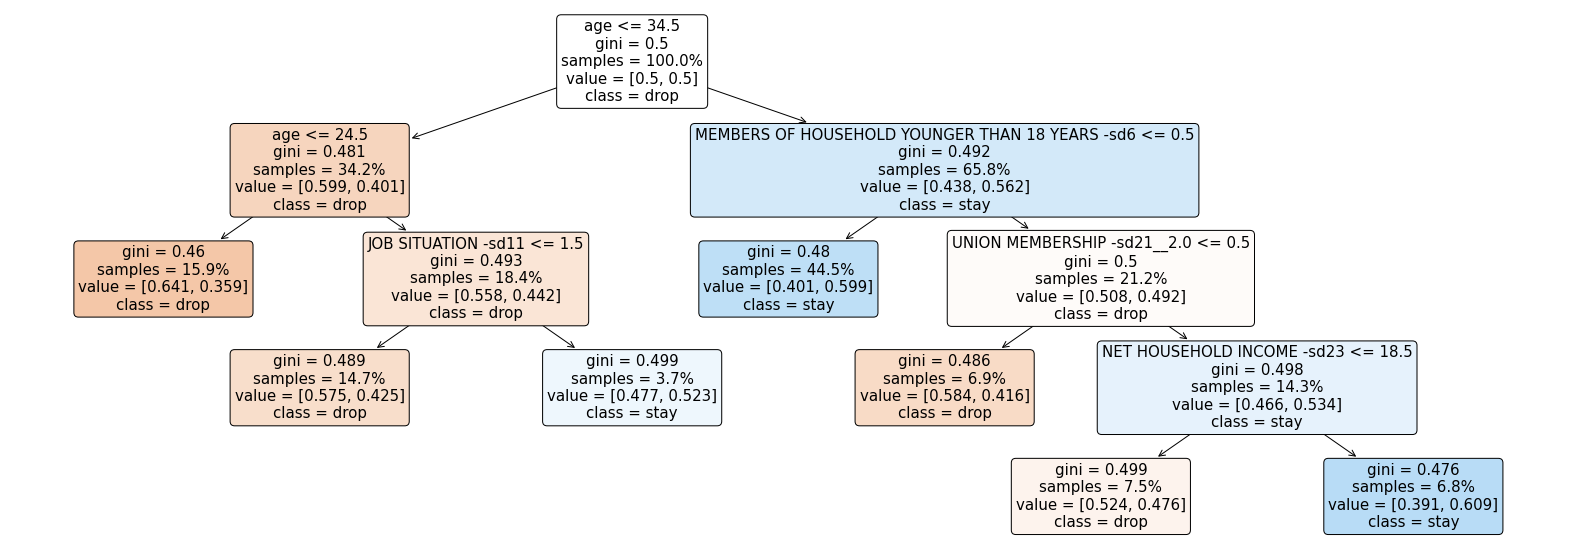

,coef
age,1.36
GENDER -sd3__3.0,-0.81
"Country of birth, repondent -sd18__3.0",0.79
OTHER OCCUPATION -sd12__2.0,-0.70
TYPE OF OCCUPATION -sd14__5.0,-0.68
"Country of birth, repondent -sd18__4.0",-0.66
"Country of birth, mother -sd19__4.0",-0.56
"Country of birth, repondent -sd18__2.0",-0.54
"Country of birth, father -sd20__4.0",0.54
CURRENT PERSONAL SITUATION -sd10__5.0,-0.52


Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=250)

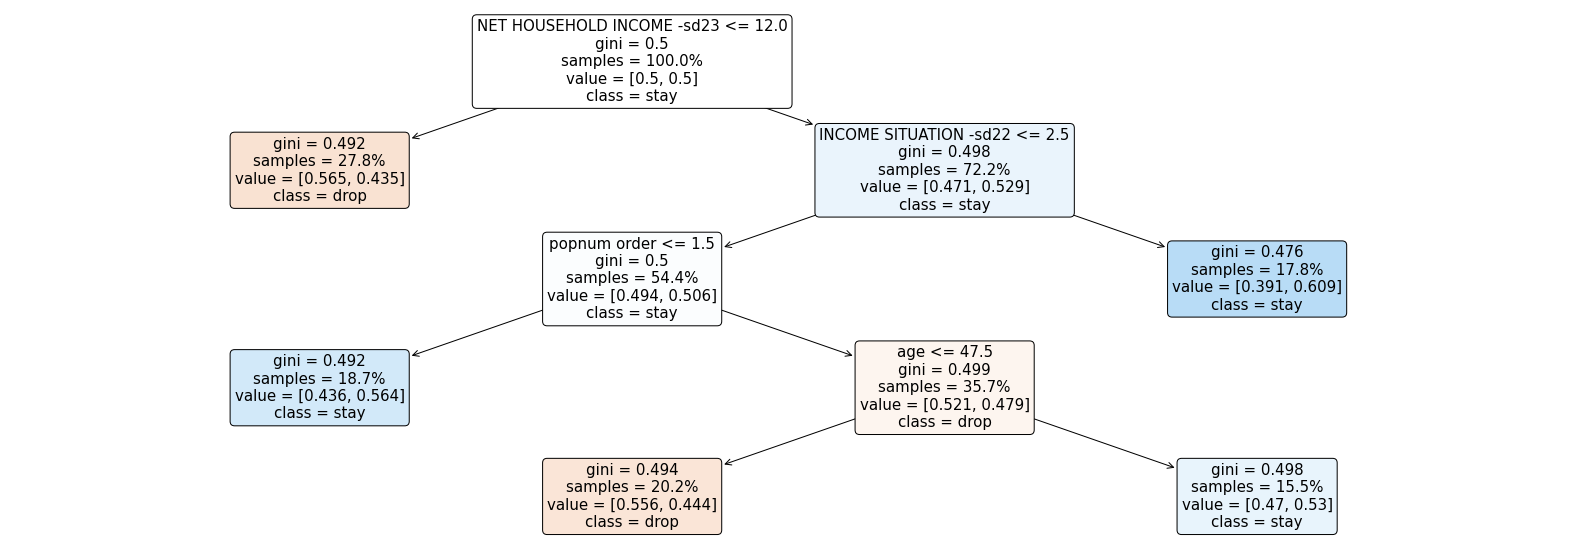

,coef
CURRENT PERSONAL SITUATION -sd10__5.0,-1.38
JOB SITUATION -sd11,1.10
OTHER OCCUPATION -sd12__3.0,1.01
"Country of birth, mother -sd19__2.0",0.91
RELIGIOUS AFFILIATION -sd8__5.0,-0.84
"Country of birth, father -sd20__3.0",-0.83
GENDER -sd3__3.0,-0.79
CURRENT PERSONAL SITUATION -sd10__9.0,0.77
CURRENT PERSONAL SITUATION -sd10__3.0,0.74
"Country of birth, repondent -sd18__3.0",0.74


Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=250)

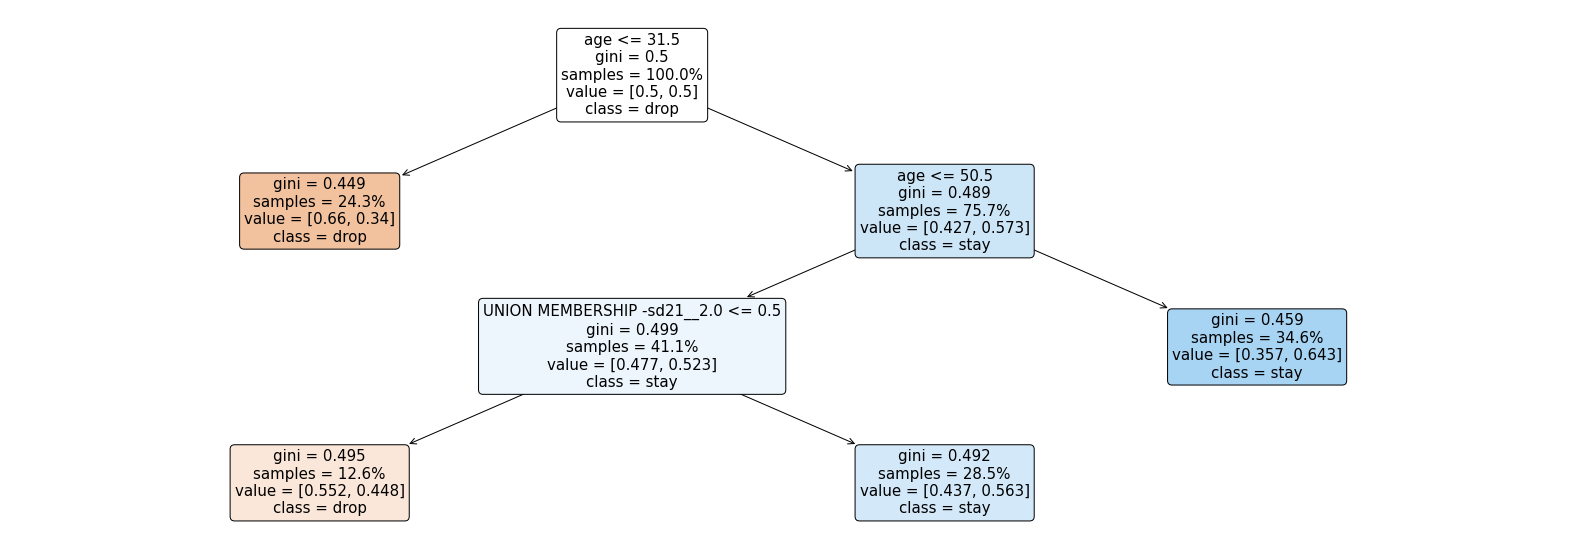

,coef
age,1.62
TYPE OF OCCUPATION -sd14__8.0,1.52
OTHER OCCUPATION -sd12__5.0,-1.04
"Country of birth, repondent -sd18__4.0",1.01
JOB SITUATION -sd11,0.87
"Country of birth, repondent -sd18__5.0",-0.86
PREVIOUS TYPE OF OCCUPATION -sd16__4.0,0.70
CURRENT PERSONAL SITUATION -sd10__8.0,-0.67
"Country of birth, repondent -sd18__2.0",0.62
FEDERAL STATE -sd4__1.0,-0.58


Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=250)

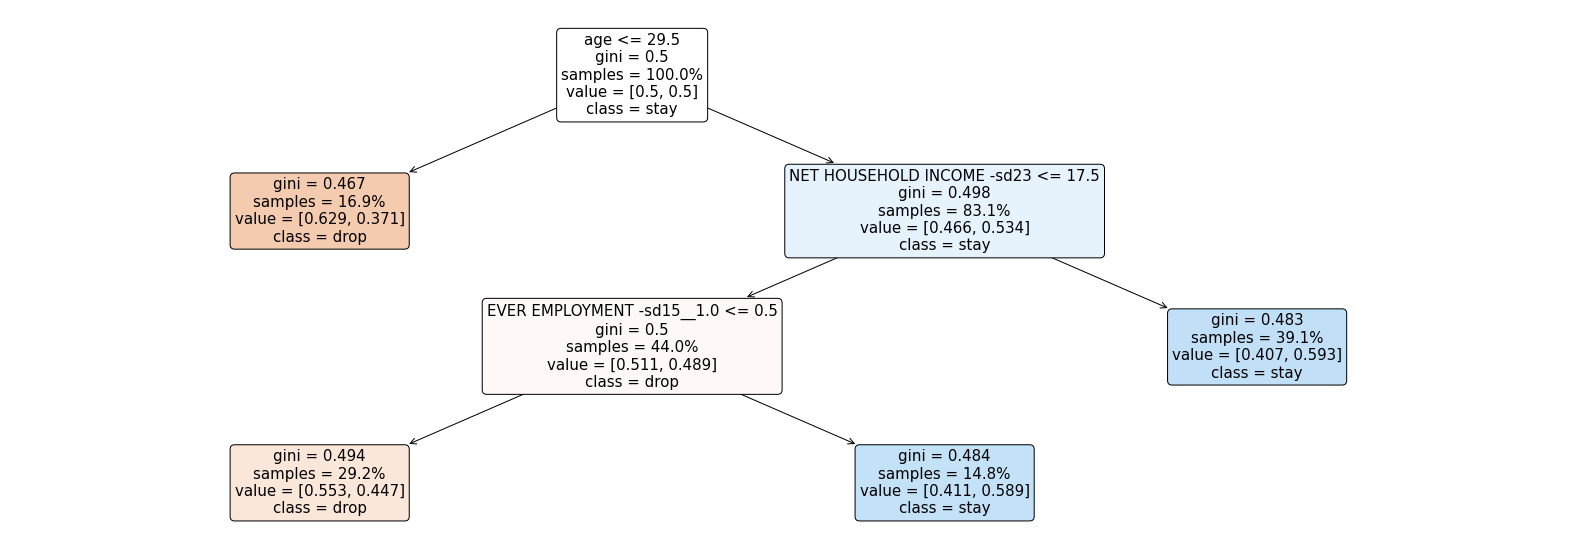

,coef
PREVIOUS TYPE OF OCCUPATION -sd16__4.0,1.31
EVER EMPLOYMENT -sd15__1.0,1.12
"Country of birth, father -sd20__3.0",1.09
"Country of birth, repondent -sd18__3.0",0.96
"Country of birth, father -sd20__5.0",-0.96
JOB SITUATION -sd11,0.92
"Country of birth, mother -sd19__3.0",-0.91
CURRENT PERSONAL SITUATION -sd10__5.0,-0.90
CURRENT PERSONAL SITUATION -sd10__7.0,0.82
"Country of birth, father -sd20__2.0",0.73


Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=250)

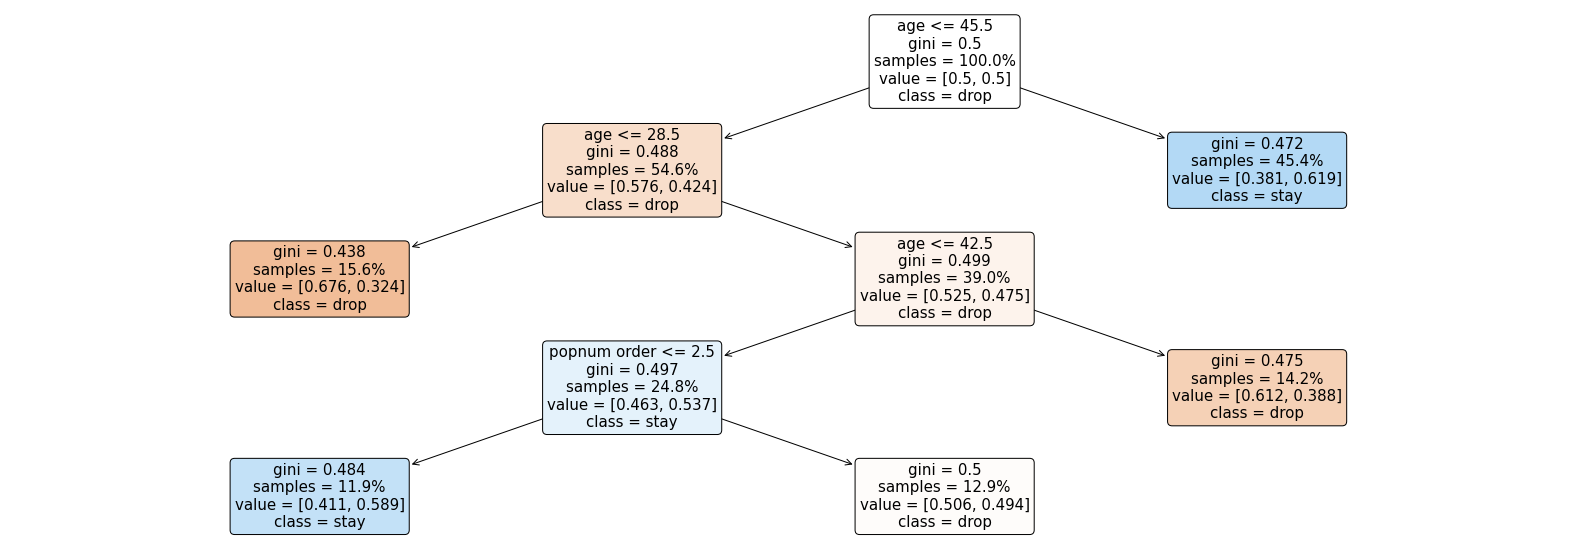

,coef
"Country of birth, mother -sd19__2.0",1.68
CURRENT PERSONAL SITUATION -sd10__11.0,1.24
age,1.15
OTHER OCCUPATION -sd12__4.0,1.10
PREVIOUS TYPE OF OCCUPATION -sd16__5.0,-1.00
PREVIOUS TYPE OF OCCUPATION -sd16__7.0,0.94
RELIGIOUS AFFILIATION -sd8__3.0,-0.77
"Country of birth, repondent -sd18__2.0",-0.63
"Country of birth, mother -sd19__5.0",-0.60
CURRENT PERSONAL SITUATION -sd10__8.0,-0.53


In [8]:
for wave in waves:
    personal, political, y = import_data(wave)
    personal.drop(["id"], axis=1, inplace=True)
    political.drop(["id"], axis=1, inplace=True)
    h2centered(f"Wave {wave}")
    X = personal
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    performance = decision_tree(X_train, y_train, X_test, y_test, names, performance)
    X_train, X_test = scale_train(X_train, X_test)
    performance = logistic_regression(
        X_train, y_train, X_test, y_test, names, performance
    )
    performance = models_without_output(
        X_train, y_train, X_test, y_test, names, performance
    )

The sign of the coefficients has a simple interpretation: __negative__ means that a higher value in this feature corresponds to a lower probability to stay - and vice versa.

## Using All features (personal, political & engineered)

Classes sizes1    3139
0     880
Name: panelpat, dtype: int64


Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=100)

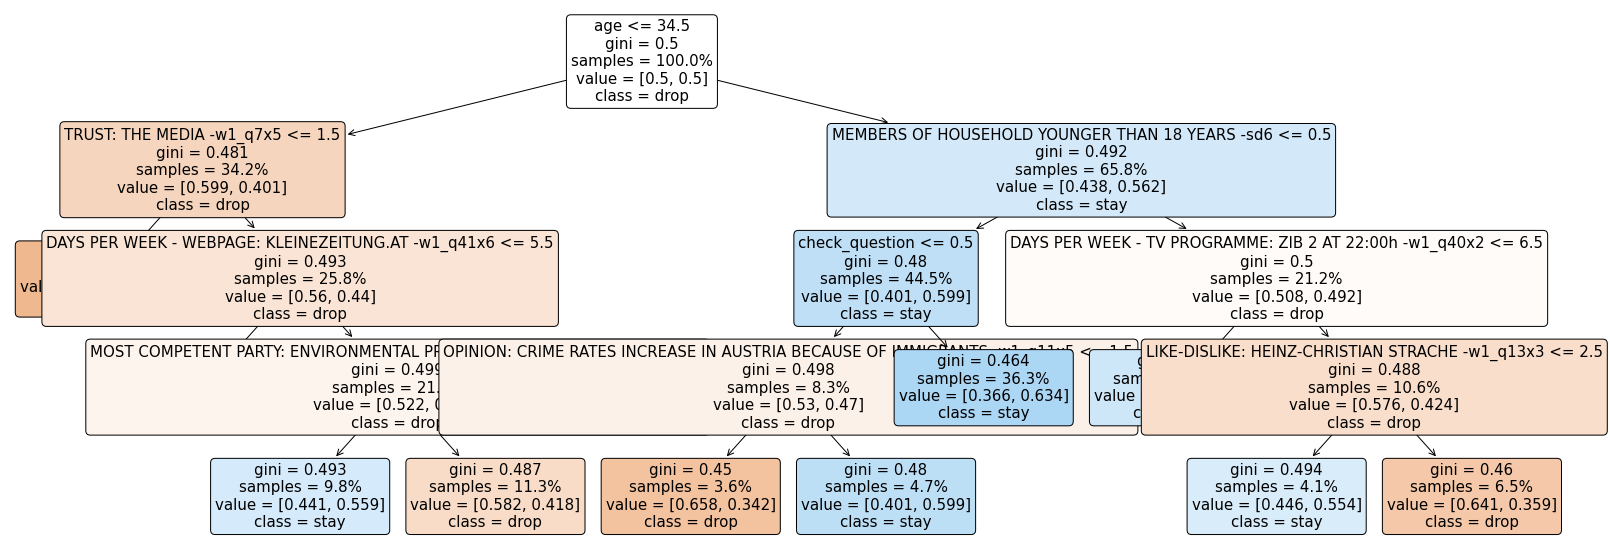

,coef
OPINION: SAME ACCESS TO SOCIAL BENEFITS: EASTERN EUROPEANS (NEW EU MEMBER STATES) -w1_q37x3,1.25
VOTE CHOICE: NATIONAL ELECTION 2013 -w1_q24__4.0,-1.11
VOTE CHOICE: NATIONAL ELECTION 2013 -w1_q24__6.0,1.02
PARTY CHOICE: HYPOTHETICAL -w1_q16__12.0,-0.88
"Country of birth, repondent -sd18__3.0",0.85
GENDER -sd3__3.0,-0.82
PARTY CHOICE: PROSPECTIVE -w1_q15__12.0,-0.81
MOST COMPETENT PARTY: IMMIGRATION -w1_q46x2__66.0,0.79
PARTY CHOICE: HYPOTHETICAL -w1_q16__3.0,-0.79
MOST COMPETENT PARTY: JOB MARKET AND EMPLOYMENT -w1_q46x1__4.0,-0.78


Classes sizes1    2683
0     450
Name: panelpat, dtype: int64


Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=100)

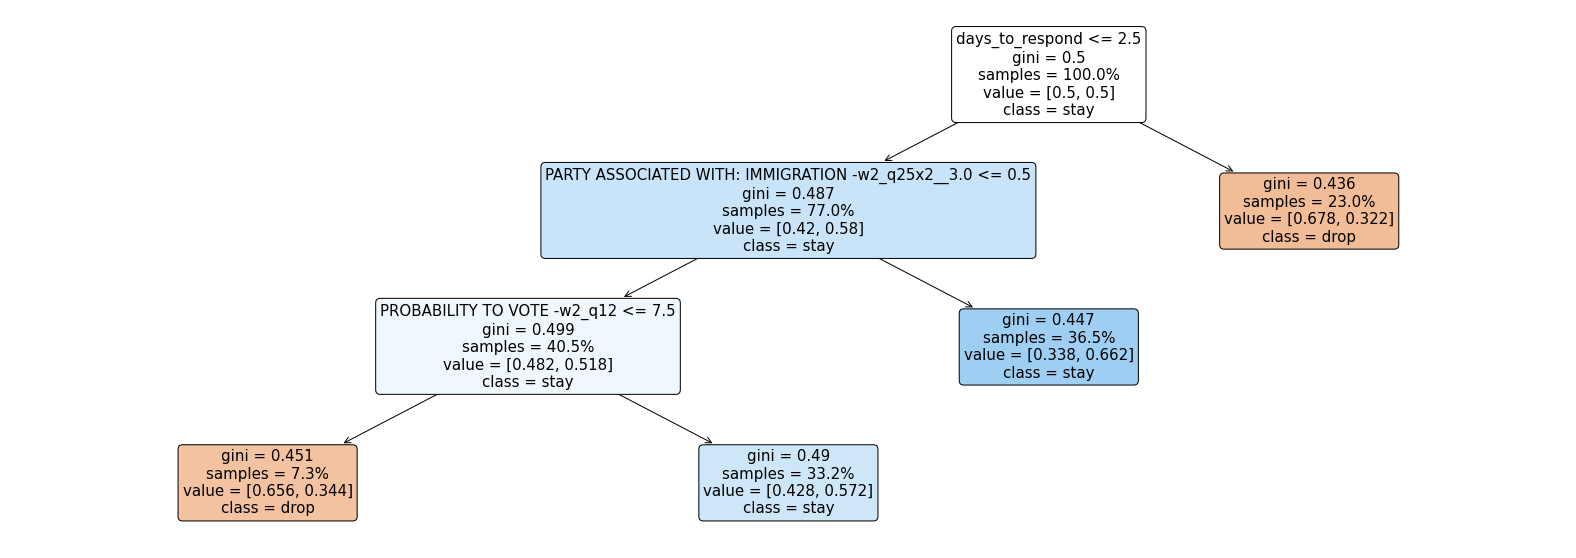

,coef
days_to_respond,-2.15
dont_know_ratio,-1.82
PARTY UNITED/DIVIDED - IMMIGRATION: OEVP -w2_q28x2,1.80
OTHER OCCUPATION -sd12__1.0,-1.32
RELIGIOUS AFFILIATION -sd8__5.0,-1.31
PARTY ASSOCIATED WITH: ENVIRONMENTAL PROTECTION -w2_q25x5__66.0,-1.29
PARTY CHOICE: HYPOTHETICAL -w2_q14__6.0,-1.14
PARTY CHOICE: PROSPECTIVE -w2_q13__8.0,-1.14
LIKE-DISLIKE: ULRIKE LUNACEK -w2_q6x4,-1.10
TOPIC POLIT. DISCUSSION - REFUSED : 1. PERSON -w2_q47x6,-1.06


Classes sizes1    2363
0     321
Name: panelpat, dtype: int64


Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=250)

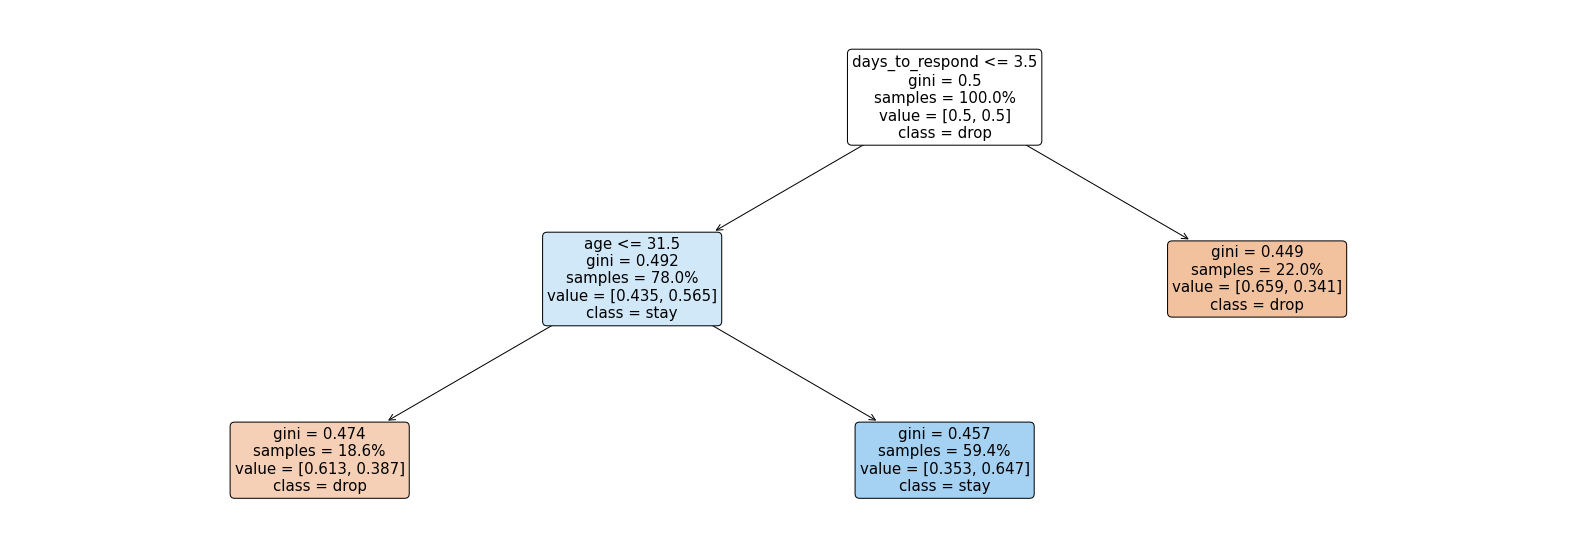

,coef
OTHER OCCUPATION -sd12__2.0,-1.76
OPINION: POLITICIANS DO NOT CARE ABOUT WHAT PEOPLE LIKE ME THINK -w3_q2x2,-1.75
days_to_respond,-1.73
OPINION: DUTY TO ACCEPT ASYLUM SEEKERS -w3_q24x4,1.72
CURRENT PERSONAL SITUATION -sd10__6.0,1.71
MOST COMPETENT PARTY: ENVIRONMENTAL PROTECTION -w3_q29x5__1.0,-1.60
PARTY CHOICE: HYPOTHETICAL -w3_q15__88.0,1.60
CURRENT PERSONAL SITUATION -sd10__7.0,1.49
PARTY CHOICE: PROSPECTIVE -w3_q14__7.0,1.47
POLITICIAN VISITED R. AT HOME/WORK DURING CAMPAIGN: THE GREENS -w3_q49x5_4,-1.43


Classes sizes1    2157
0     208
Name: panelpat, dtype: int64


Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=100)

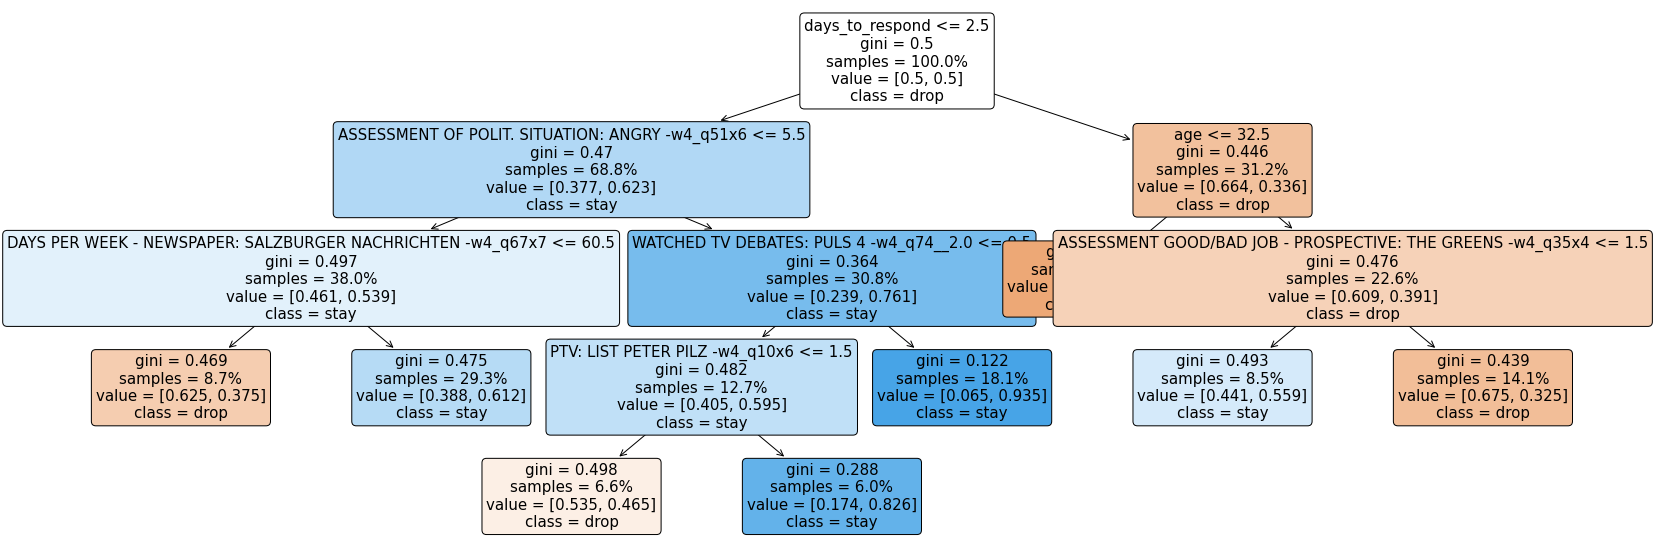

,coef
days_to_respond,-3.18
PARTY CHOICE: PROSPECTIVE -w4_q16__12.0,-2.11
DAYS PER WEEK - WEBPAGE: DIEPRESSE.COM -w4_q69x7,2.11
R. RECEIVED A CALL OR A TEXT MESSAGE DURING CAMPAIGN: DONT KNOW -w4_q59x2_8,-2.08
PARTY CHOICE: HYPOTHETICAL -w4_q18__99.0,1.87
PTV: SPOE -w4_q10x1,1.84
INTERVIEW DURATION IN SECONDS -w4_intdur,1.81
R. RECEIVED INFORMATION MATERIAL/FREEBIE DURING CAMPAIGN: NEOS -w4_q59x3_5,1.79
OPINION: VOTING IS A DUTY OF EVERY CITIZEN -w4_q39x1,-1.77
DAYS PER WEEK - NEWSPAPER: HEUTE -w4_q67x6,-1.74


Classes sizes1    1939
0     212
Name: panelpat, dtype: int64


Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=250)

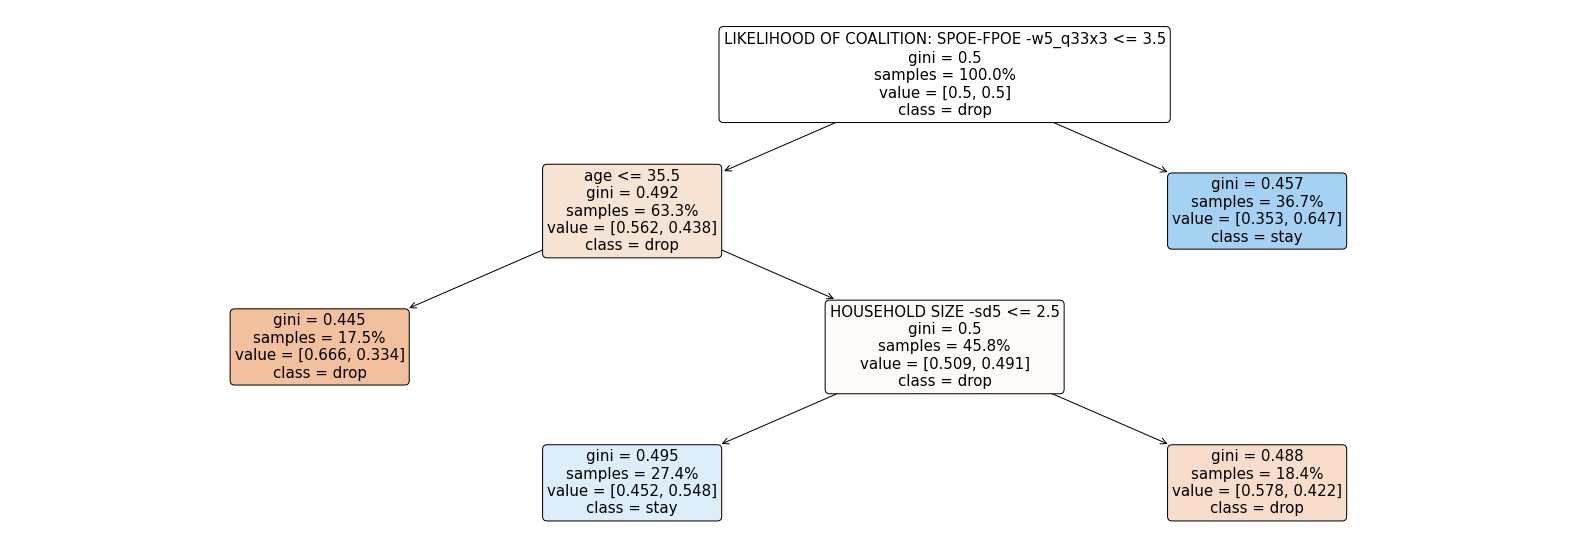

,coef
HOUSEHOLD SIZE -sd5,-2.43
R. RECEIVED A CALL OR A TEXT MESSAGE DURING CAMPAIGN: NEOS -w5_q45x2_5,-2.23
days_to_respond,-2.12
VOTE CHOICE: NATIONAL ELECTION 2013 -w5_q10__4.0,-1.89
PREVIOUS TYPE OF OCCUPATION -sd16__5.0,-1.76
R. VISITED FACEBOOK PAGE DURING CAMPAIGN: THE GREENS -w5_q47x2_4,1.73
INTERVIEW DURATION IN SECONDS -w5_intdur,-1.73
R. VISITED FACEBOOK PAGE OF PARTIES/CANDIDATES DURING CAMPAIGN (YES/NO) -w5_q46x2__88.0,-1.68
R. RECEIVED LETTER/FLYER/E-MAIL DURING CAMPAIGN: LIST PETER PILZ -w5_q45x1_6,1.63
GOVERNMENT FORMATION - NO COALITION: REFUSED -w5_q39x9,-1.54


In [9]:
for wave in waves:
    personal, political, y = import_data(wave)
    personal.drop(["id"], axis=1, inplace=True)
    political.drop(["id"], axis=1, inplace=True)
    h2centered(f"Wave {wave}")
    X = pd.concat([personal, political], axis=1)
    # removing redundant features and labels
    dte = X.filter(like="_dte", axis=1)
    X = X.drop(["participated_only_once", dte.columns[0]], axis=1)
    # exclude rejoiners
    df = pd.concat([X, y], axis=1)
    # exclude rejoiners
    df = df[df["whether_dropped_before"].isin([0])]
    y = df["panelpat"]
    X = df.drop(["panelpat"], axis=1)
    print(f"Classes sizes{y.value_counts()}")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    performance = decision_tree(X_train, y_train, X_test, y_test, names, performance)
    X_train, X_test = scale_train(X_train, X_test)
    performance = logistic_regression(
        X_train, y_train, X_test, y_test, names, performance
    )
    performance = models_without_output(
        X_train, y_train, X_test, y_test, names, performance
    )

We see that the some of the most important features for the DT model were:
- how many days it took people to respond to the survey
- and how propable they think they are to vote in the next election

> Both, the decision tree model and the logistic regression agree that the `days_to_respond` feature is the most relevant one. The more days it took respondents to answer the survey, the more likely they are to not respond at all in the next wave.

# Results

In [10]:
performance = prepare_to_plot(performance)

In [11]:
@interact
def plot_results(wave=waves):
    fig = px.scatter(
        performance.loc[performance["Wave"] == wave],
        title="Precision/recall/accuracy scatter plots",
        x="Recall",
        y="Precision",
        color="Model",
        size="Accuracy",
        facet_col="Split",
        facet_row="Subset",
    )
    fig.update_layout(
        legend=dict(
            font=dict(size=12),
            orientation="h",
            yanchor="bottom",
            y=1.05,
            title=" ",
            xanchor="right",
            x=1,
        ),
        width=900,
        height=600,
        legend_title=dict(font=dict(size=8)),
    )
    # subplot title fonts size
    fig.update_annotations(font_size=12)
    fig.update_xaxes(dict(tickfont=dict(size=12)), title_font=dict(size=12))
    fig.update_yaxes(dict(tickfont=dict(size=12)), title_font=dict(size=12))
    fig.show()

interactive(children=(Dropdown(description='wave', options=('2', '3', '4', '5', '6'), value='2'), Output()), _…

Although the newly introduced features in the larger dataset (using all questions+engineered features) seemed to be very relevant to the models it is not so clear whether they performed better. 

# References

1. Wagner, Markus, Julian Aichholzer, Jakob-Moritz Eberl, Thomas Meyer, Nicolai Berk, Nico Büttner, Hajo
Boomgaarden, Sylvia Kritzinger and Wolfgang C. Müller (2020). AUTNES Online Panel Study 2017 (SUF
Edition). Vienna: AUSSDA (doi:10.11587/I7QIYJ).

2. Wagner, Markus, Julian Aichholzer, Jakob-Moritz Eberl, Thomas Meyer, Nicolai Berk, Nico Büttner, Hajo
Boomgaarden, Sylvia Kritzinger and Wolfgang C. Müller (2020). AUTNES Online Panel Study 2017 –
Documentation. Vienna: AUSSDA (doi:10.11587/I7QIYJ).